## Data loading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_non_ftc_collab/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field != pr_merged_key)]

df[independent_fields].describe()

class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f'{class_imbalance=}')

Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + EcosystemExperienceSubmitterPullReques

In [2]:
# FTC selection

df = df[df[ftc_key] == False]
not_applicable_fields = [ftc_key]
df = df.drop(not_applicable_fields, axis=1)
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field != pr_merged_key
                          and field not in not_applicable_fields)]
print(len(df))

class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f'{class_imbalance=}')

df = df.reset_index(drop=True)
print(independent_fields)
df.describe()


796181
class_imbalance=5.997055928568917
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependency

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,7.961810e+05,7.961810e+05,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,...,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000,796181.000000
mean,1.614234e+08,5.062672e+06,931.445137,0.773661,0.477392,0.139262,0.078235,0.380626,0.124879,0.352161,...,0.101815,0.170263,0.016190,0.027695,0.012462,0.022788,0.114191,0.097218,0.053923,0.073894
std,9.897550e+07,7.943183e+06,2550.549376,0.363284,0.457044,0.337262,0.259882,0.217285,0.075801,0.175499,...,0.131882,0.190187,0.063966,0.093940,0.060221,0.093729,0.109650,0.104940,0.114488,0.128862
min,6.870000e+02,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.603451e+07,4.504900e+05,68.000000,0.750000,0.000000,0.000000,0.000000,0.198312,0.075257,0.214353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028426,0.016251,0.000000,0.000000
50%,1.563441e+08,1.596303e+06,255.000000,0.976744,0.545455,0.000000,0.000000,0.393364,0.075257,0.352252,...,0.000000,0.122888,0.000000,0.000000,0.000000,0.000000,0.086419,0.064835,0.000000,0.000000
75%,2.412172e+08,6.174737e+06,808.000000,1.000000,0.967742,0.000000,0.000000,0.545871,0.150513,0.479409,...,0.178763,0.310134,0.000000,0.000000,0.000000,0.000000,0.168216,0.143414,0.038858,0.105946
max,3.617734e+08,5.943086e+07,82974.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.993928,1.000000,...,0.854348,0.886728,1.000000,1.000000,0.999796,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
# Filters for collab data.

from python_proj.utils.util import get_matching

collab_fields = get_matching(independent_fields, r'.*(Weighted|Intensity).*')
print(collab_fields)


df = df[(df[collab_fields].gt(0)).any(axis=1)]

print(len(df))
df = df.reset_index(drop=True)
df.describe()

<generator object get_matching at 0x7f5c20d2ae30>
726379


,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,7.263790e+05,7.263790e+05,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,...,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000,726379.000000
mean,1.603990e+08,4.895860e+06,964.680485,0.795357,0.510184,0.149366,0.083054,0.383302,0.124393,0.360853,...,0.110410,0.184916,0.017587,0.030223,0.013487,0.024812,0.125165,0.106560,0.059105,0.080995
std,9.870670e+07,7.774962e+06,2585.999665,0.342012,0.453803,0.347089,0.266977,0.210570,0.075289,0.172807,...,0.134319,0.192160,0.066520,0.097837,0.062663,0.097716,0.108650,0.105238,0.118578,0.132763
min,6.870000e+02,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.501516e+07,4.413460e+05,76.000000,0.800000,0.000000,0.000000,0.000000,0.208107,0.075257,0.232795,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043197,0.027496,0.000000,0.000000
50%,1.549475e+08,1.530467e+06,274.000000,0.979592,0.687500,0.000000,0.000000,0.399186,0.075257,0.364225,...,0.089382,0.122888,0.000000,0.000000,0.000000,0.000000,0.098036,0.075649,0.000000,0.000000
75%,2.398418e+08,5.971264e+06,850.000000,1.000000,0.978723,0.000000,0.000000,0.545086,0.150513,0.485763,...,0.178763,0.329357,0.000000,0.000000,0.000000,0.000000,0.178484,0.153598,0.054379,0.125778
max,3.617734e+08,5.899647e+07,82974.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.993813,1.000000,...,0.854348,0.886728,1.000000,1.000000,0.999796,1.000000,1.000000,1.000000,1.000000,1.000000


## Model Creation

### Re-usable Functions

To create a random forest model and to perform k-fold cross validation.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "precision": precision_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "recall": recall_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights)
    }


def create_model(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series,
    random_state: int | None = None,
):
    # Model creation and predictions.
    if random_state is None:
        random_state = seed_counter.get_next()
    print(f'{random_state=}')
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state)

    rf.fit(train_predictors, train_labels)

    predictions = rf.predict(test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f'{metrics=}\n')

    # Other metrics.
    print(f'Confusion matrix:\n{conf}\n')
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics


In [5]:
from typing import Iterator
import regex as re
from sklearn.model_selection import KFold
from python_proj.utils.mt_utils import parallelize_tasks


def kfold_rf_evaluation(
    _df: pd.DataFrame,
    predictor_fields: Iterator[str],
    k: int = 5
):
    random_state = seed_counter.get_next()

    def create_model_for_fold(task, *args, **kwargs):
        train_idx, test_idx = task
        train = _df.loc[train_idx, :]
        test = _df.loc[test_idx, :]
        train_predictors = train[predictor_fields]
        train_labels = train[pr_merged_key]
        test_predictors = test[predictor_fields]
        test_labels = test[pr_merged_key]
        _, rf_metrics = create_model(
            train_predictors,
            train_labels,
            test_predictors,
            test_labels,
            random_state
        )
        return rf_metrics

    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=seed_counter.get_next()
    )
    tasks = kf.split(_df)
    models_and_f1s = parallelize_tasks(
        tasks,
        create_model_for_fold,
        thread_count=min(k, 12),
        return_results=True,
        print_lifetime_events=False
    )

    f1_scores = [entry['f1'] for entry in models_and_f1s]
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)

    return f1_scores, f1_mean, f1_std


### Full Model

In [6]:
f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields)

print("\nPerformance metrics full model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')


random_state=43
random_state=43random_state=43random_state=43


random_state=43
metrics={'accuracy': 0.9345796965775489, 'precision': 0.944464023044864, 'recall': 0.982036739050775, 'f1': 0.9628839890339059}

Confusion matrix:
[[ 12493   7249]
 [  2255 123279]]

Classification report:
              precision    recall  f1-score   support

       False       0.85      0.63      0.72     19742
        True       0.94      0.98      0.96    125534

    accuracy                           0.93    145276
   macro avg       0.90      0.81      0.84    145276
weighted avg       0.93      0.93      0.93    145276

metrics={'accuracy': 0.9357154657341887, 'precision': 0.9459902678263535, 'recall': 0.9817795733986543, 'f1': 0.9635527039842643}

Confusion matrix:
[[ 12490   7048]
 [  2291 123447]]

Classification report:
              precision    recall  f1-score   support

       False       0.85      0.64      0.73     19538
        True       0.95      0.98      0.96    125738

    accuracy   

### Control + Intra-project Model

In [7]:
# Creates control model + Intra fields.
contr_with_intra = [field for field in independent_fields
                    if re.match(r'.*(Control|Intra).*',field)]
contr_with_intra = list(contr_with_intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, contr_with_intra)

print("\nPerformance metrics control + intra model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
random_state=45
random_state=45random_state=45

random_state=45
random_state=45
metrics={'accuracy': 0.9290247528841653, 'precision': 0.9423874966316357, 'recall': 0.977417551704863, 'f1': 0.9595829331869942}

Confusion matrix:
[[ 12563   7483]
 [  2828 122402]]

Classification report:
              precision    recall  f1-score   support

       False       0.82      0.63      0.71     20046
        True       0.94      0.98   

### Collaboration and Ecosystem Model

In [8]:
# Creates measured information model.
non_control_fields_wo_intra = [field for field in independent_fields
                               if not re.match(r'.*(Intra|Control).*', field)]
non_control_fields_wo_intra = list(non_control_fields_wo_intra)
print(non_control_fields_wo_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, non_control_fields_wo_intra)

print("\nPerformance metrics non-control model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

## Feature Explanation and Evaluation

### Partial Dependence Plots

In [9]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
        rf_model: RandomForestRegressor,
        used_predictors: pd.DataFrame,
        model_name: str = ""):

    # Collective partial dependence plot.
    PartialDependenceDisplay.from_estimator(
        rf_model, used_predictors, used_predictors.columns,
        percentiles=(0.01,0.99))

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata())
                        for line in ax.lines])
        lines.extend(__lines)

    for (x, y), label in zip(lines, used_predictors.columns):
        plt.clf()
        plt.plot(x, y, linestyle='-', color='#e69d00')
        plt.xlabel(label)
        plt.ylabel('Partial Dependence')
        plt.tight_layout()
        output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
        safe_save_fig(output_path)


In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


random_state=49
metrics={'accuracy': 0.9341735730609323, 'precision': 0.944193709053293, 'recall': 0.9818329588373094, 'f1': 0.9626455526606695}

Confusion matrix:
[[ 12491   7283]
 [  2280 123222]]

Classification report:
              precision    recall  f1-score   support

       False       0.85      0.63      0.72     19774
        True       0.94      0.98      0.96    125502

    accuracy                           0.93    145276
   macro avg       0.89      0.81      0.84    145276
weighted avg       0.93      0.93      0.93    145276



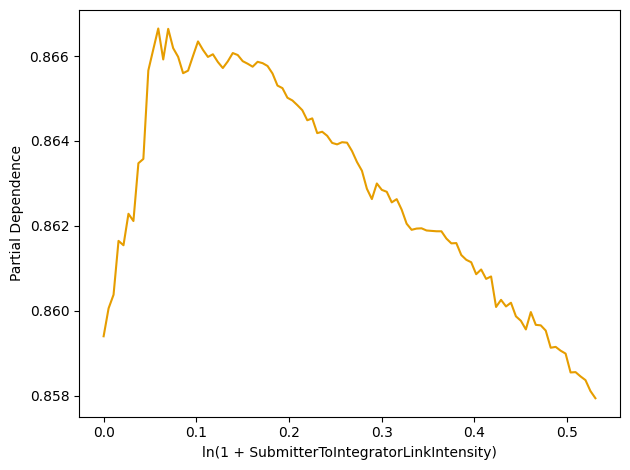

In [11]:
full_rf_model, _ = create_model(
    train_predictors, train_dependent,
    test_predictors, test_dependent
)

create_partial_dependence_plots(
    full_rf_model,
    test_predictors,
    model_name="full_model"
)


### Mean decrease in Impurity

/tmp/ipykernel_93954/2882849337.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


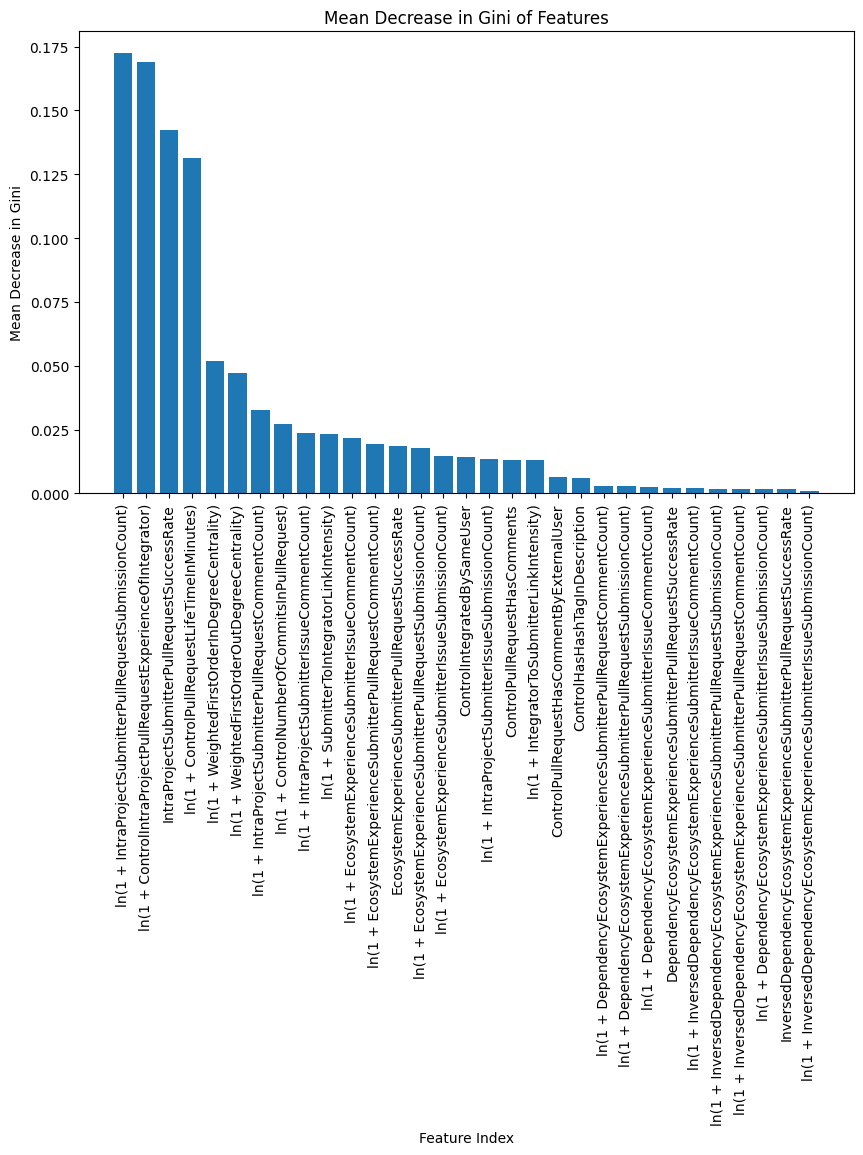

ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.1723
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.1691
IntraProjectSubmitterPullRequestSuccessRate: 0.1423
ln(1 + ControlPullRequestLifeTimeInMinutes): 0.1312
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0520
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0473
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.0327
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0272
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.0237
ln(1 + SubmitterToIntegratorLinkIntensity): 0.0233
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0218
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.0192
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0184
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0177
ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount): 0.0145
ControlIntegratedBySameUser: 0.0143
ln(1 + IntraProjectSubmitterIssueSubmissionCount): 0.0136
ControlPullRequest

In [12]:
feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease in Gini')
plt.title('Mean Decrease in Gini of Features')
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f'{field}: {importance:.04f}')


### Cluster Inverse-ablation

Creates models with subsets of the features to test their impact on the predictions in isolation.

In [13]:
from python_proj.utils.util import get_matching

control_features = list(get_matching(independent_fields, r'.*Control.*'))
intra_features = get_matching(
    independent_fields, r'^(?!.*Control).*(?=Intra).*')
eco_features = get_matching(
    independent_fields, r'^(?!.*Dependency).*(?=Ecosystem).*')
deco_features = get_matching(
    independent_fields, r'^(?!.*Inverse).*(?=Dependency).*')
ideco_features = get_matching(independent_fields, r'.*(?=Inverse).*')
coll_features = get_matching(independent_fields, r'.*(Weighted|LinkIntensity).*')

clusters = [
    ('control', control_features),
    ("intra", intra_features),
    ("eco", eco_features),
    ("deco", deco_features),
    ("ideco", ideco_features),
    ("coll", coll_features)
]

results = {}
for (cluster_name, cluster) in clusters:
    cluster = list(cluster)
    print(
        f'Starting cluster ablation with "{cluster_name}" fields excluded: {list(cluster)}.')
    used_fields = [field for field in independent_fields
                   if field not in cluster]
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, cluster)
    results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f'Performance metrics of cluster {cluster_name}\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n')

for cluster_name, (f1_scores, f1_mean, f1_std) in results.items():
    print(
        f'Performance metrics of cluster {cluster_name}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n')


Starting cluster ablation with "control" fields excluded: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].
random_state=50
random_state=50
random_state=50
random_state=50
random_state=50
metrics={'accuracy': 0.863480547371899, 'precision': 0.8977699786863886, 'recall': 0.9501131798762992, 'f1': 0.9232002416328806}

Confusion matrix:
[[  6238  13574]
 [  6259 119205]]

Classification report:
              precision    recall  f1-score   support

       False       0.50      0.31      0.39     19812
        True       0.90      0.95      0.92    125464

    accuracy                           0.86    145276
   macro avg       0.70      0.63      0.65    145276
weighted avg       0.84      0.86      0.85    145276

metrics={'accuracy': 0.8

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [14]:
import random

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [
    random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=:.03f}.")
print(json.dumps(metrics, indent=4))


Probability guesser metrics with probability_true=0.857.
{
    "accuracy": 0.7593683746799196,
    "precision": 0.8638350880012858,
    "recall": 0.8564564708132141,
    "f1": 0.8601299553478544
}


### Variable Interactions

Generates models excluding the features that are interacting with each other (PR success rate etc.) to see their standalone impacts.

In [15]:
import copy
from python_proj.utils.util import get_matching

sr_features = get_matching(independent_fields, r'.*SuccessRate.*')
prc_features = get_matching(independent_fields, r'.*PullRequestSubmission.*')
prcc_features = get_matching(
    independent_fields, r'.*PullRequestCommentCount.*')
ic_features = get_matching(independent_fields, r'.*IssueSubmission.*')
icc_features = get_matching(independent_fields, r'.*IssueCommentCount.*')

feature_groups = {
    "sr_features": list(sr_features),
    "prc_features": list(prc_features),
    "prcc_features": list(prcc_features),
    "ic_features": list(ic_features),
    "icc_features": list(icc_features)
}

random_seed = seed_counter.get_next()


def __create_without_feature_groups(task, *args, **kwargs):
    feature_groups, model_name = task
    
    # Loads features.
    used_features = independent_fields
    for _, features in feature_groups.items():
        for feature in features:
            if feature in used_features:
                used_features.remove(feature)
    
    # Creates model etc.
    print(f'{model_name=}, {used_features=}\n', end='')
    used_train_predictors: pd.DataFrame = train_predictors[used_features]
    rf_model, _ = create_model(
        used_train_predictors, train_dependent,
        test_predictors[used_features], test_dependent,
        random_seed
    )

    create_partial_dependence_plots(
        rf_model, used_train_predictors, model_name=model_name)


tasks = []
for i, (name, features) in enumerate(feature_groups.items()):
    removed_features = copy.deepcopy(feature_groups)
    del removed_features[name]
    new_task = (removed_features, name)
    tasks.append(new_task)

parallelize_tasks(tasks, __create_without_feature_groups,
                  print_lifetime_events=False)


model_name='prcc_features', used_features=['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + WeightedFirstOrderInDegreeCentrality)', 'ln(1 + WeightedFirstOrderOutDegreeCentrality)', 'ln(1 + IntegratorToSubmitterLinkIntensity)', 'ln(1 + SubmitterToIntegratorLinkIntensity)']
model_name='prc_features', used_features=['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 +